# Spotify Streaming Analytics: What Drives Song Popularity?

**Author:** Nischal Anagisetty  
**Dataset:** Kaggle Spotify Tracks Dataset (114K+ tracks)  
**Business Context:** Analyzing music streaming trends to understand what drives song popularity and how platforms can optimize recommendations, playlists, and content curation for user engagement.

---

### Key Questions
1. What audio features predict track popularity?
2. How do genres differ in audio characteristics and popularity?
3. What combination of features makes a song "danceable"?
4. Do explicit songs perform differently than clean tracks?
5. How do tempo and mood interact to affect popularity?

In [1]:
# ============================================================
# CELL 1: Imports and Setup
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from matplotlib.patches import Rectangle
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)

# --- Style configuration ---
sns.set_style('whitegrid')
PALETTE = ['#1a1a2e', '#16213e', '#0f3460', '#533483', '#7b2d8e',
           '#a855f7', '#6366f1', '#818cf8', '#a78bfa', '#c4b5fd']
sns.set_palette(PALETTE)

plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.3
})

# --- Output directories ---
FIG_DIR = Path('../outputs/figures')
REPORT_DIR = Path('../outputs/reports')
FIG_DIR.mkdir(parents=True, exist_ok=True)
REPORT_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH = Path('../data/dataset.csv')

print('Setup complete.')
print(f'Figures  -> {FIG_DIR.resolve()}')
print(f'Reports  -> {REPORT_DIR.resolve()}')

Setup complete.
Figures  -> /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/spotify-streaming-analytics/outputs/figures
Reports  -> /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/spotify-streaming-analytics/outputs/reports


---
## Data Loading & Initial Exploration
Before any analysis, we profile the raw data: shape, types, completeness, and summary statistics.

In [2]:
# ============================================================
# CELL 2: Data Loading and Initial Exploration
# ============================================================

df_raw = pd.read_csv(DATA_PATH, index_col=0)

print('=' * 60)
print('DATASET OVERVIEW')
print('=' * 60)
print(f'Shape: {df_raw.shape[0]:,} tracks  x  {df_raw.shape[1]} columns\n')

print('Columns & Data Types:')
print('-' * 40)
for col in df_raw.columns:
    print(f'  {col:<25s} {str(df_raw[col].dtype)}')

print(f'\nMissing Values:')
print('-' * 40)
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
miss_df = pd.DataFrame({'count': missing, 'pct': missing_pct})
if missing.sum() > 0:
    print(miss_df[miss_df['count'] > 0].to_string())
else:
    print('  No missing values detected.')

print(f'\nDuplicate Rows: {df_raw.duplicated().sum():,}')

print('\nFirst 10 Rows:')
display(df_raw.head(10))

print('\nDescriptive Statistics (Numeric):')
display(df_raw.describe().round(3))

DATASET OVERVIEW
Shape: 114,000 tracks  x  20 columns

Columns & Data Types:
----------------------------------------
  track_id                  object
  artists                   object
  album_name                object
  track_name                object
  popularity                int64
  duration_ms               int64
  explicit                  bool
  danceability              float64
  energy                    float64
  key                       int64
  loudness                  float64
  mode                      int64
  speechiness               float64
  acousticness              float64
  instrumentalness          float64
  liveness                  float64
  valence                   float64
  tempo                     float64
  time_signature            int64
  track_genre               object

Missing Values:
----------------------------------------
            count  pct
artists         1  0.0
album_name      1  0.0
track_name      1  0.0

Duplicate Rows: 450

First 10

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic



Descriptive Statistics (Numeric):


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000,114000.000
mean,33.239,228029.153,0.567,0.641,5.309,-8.259,0.638,0.085,0.315,0.156,0.214,0.474,122.148,3.904
std,22.305,107297.713,0.174,0.252,3.560,5.029,0.481,0.106,0.333,0.310,0.190,0.259,29.978,0.433
min,0.000,0.000,0.000,0.000,0.000,-49.531,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,17.000,174066.000,0.456,0.472,2.000,-10.013,0.000,0.036,0.017,0.000,0.098,0.260,99.219,4.000
50%,35.000,212906.000,0.580,0.685,5.000,-7.004,1.000,0.049,0.169,0.000,0.132,0.464,122.017,4.000
75%,50.000,261506.000,0.695,0.854,8.000,-5.003,1.000,0.084,0.598,0.049,0.273,0.683,140.071,4.000
max,100.000,5237295.000,0.985,1.000,11.000,4.532,1.000,0.965,0.996,1.000,1.000,0.995,243.372,5.000


---
## Data Cleaning & Feature Engineering
We remove duplicates, handle any missing values, and create derived features that will power our analysis.

In [3]:
# ============================================================
# CELL 3: Data Cleaning
# ============================================================

df = df_raw.copy()

# --- Drop exact duplicates ---
before = len(df)
df = df.drop_duplicates()
print(f'Dropped {before - len(df):,} exact duplicate rows.')

# --- Handle missing values ---
missing_before = df.isnull().sum().sum()
df = df.dropna(subset=['track_name', 'artists'])
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
missing_after = df.isnull().sum().sum()
print(f'Missing values resolved: {missing_before} -> {missing_after}')

# --- Derived features ---
df['duration_minutes'] = df['duration_ms'] / 60_000

df['popularity_category'] = pd.cut(
    df['popularity'],
    bins=[-1, 50, 70, 100],
    labels=['Low (<50)', 'Medium (50-70)', 'High (>70)']
)

df['tempo_category'] = pd.cut(
    df['tempo'],
    bins=[0, 100, 130, 300],
    labels=['Slow (<100)', 'Medium (100-130)', 'Fast (>130)']
)

print(f'\nCleaned dataset: {df.shape[0]:,} tracks  x  {df.shape[1]} columns')
print(f'New features: duration_minutes, popularity_category, tempo_category')

print(f'\nPopularity tiers:')
print(df['popularity_category'].value_counts().sort_index().to_string())

print(f'\nTempo tiers:')
print(df['tempo_category'].value_counts().sort_index().to_string())

print()
df.info()

Dropped 450 exact duplicate rows.
Missing values resolved: 3 -> 0

Cleaned dataset: 113,549 tracks  x  23 columns
New features: duration_minutes, popularity_category, tempo_category

Popularity tiers:
Low (<50)         85800
Medium (50-70)    22906
High (>70)         4843

Tempo tiers:
Slow (<100)         29564
Medium (100-130)    42334
Fast (>130)         41494

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113549 entries, 0 to 113999
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   track_id             113549 non-null  object  
 1   artists              113549 non-null  object  
 2   album_name           113549 non-null  object  
 3   track_name           113549 non-null  object  
 4   popularity           113549 non-null  int64   
 5   duration_ms          113549 non-null  int64   
 6   explicit             113549 non-null  bool    
 7   danceability         113549 non-null  float64 
 8 

---
## Q1 : What Audio Features Predict Popularity?

**Business Context:** Understanding which measurable audio characteristics correlate with higher popularity lets streaming platforms weight these signals in recommendation algorithms and helps A&R teams spot high-potential tracks before they trend.

PEARSON CORRELATIONS:  Audio Features  vs.  Popularity
  danceability          r = +0.0344   p = 4.25e-31  ***
  energy                r = -0.0024   p = 4.10e-01  ns
  loudness              r = +0.0474   p = 2.05e-57  ***
  speechiness           r = -0.0455   p = 5.02e-53  ***
  acousticness          r = -0.0224   p = 4.92e-14  ***
  instrumentalness      r = -0.0947   p = 1.56e-224  ***
  liveness              r = -0.0057   p = 5.62e-02  ns
  valence               r = -0.0411   p = 1.20e-43  ***
  tempo                 r = +0.0122   p = 4.01e-05  ***

Top 3 correlated features: instrumentalness, loudness, speechiness


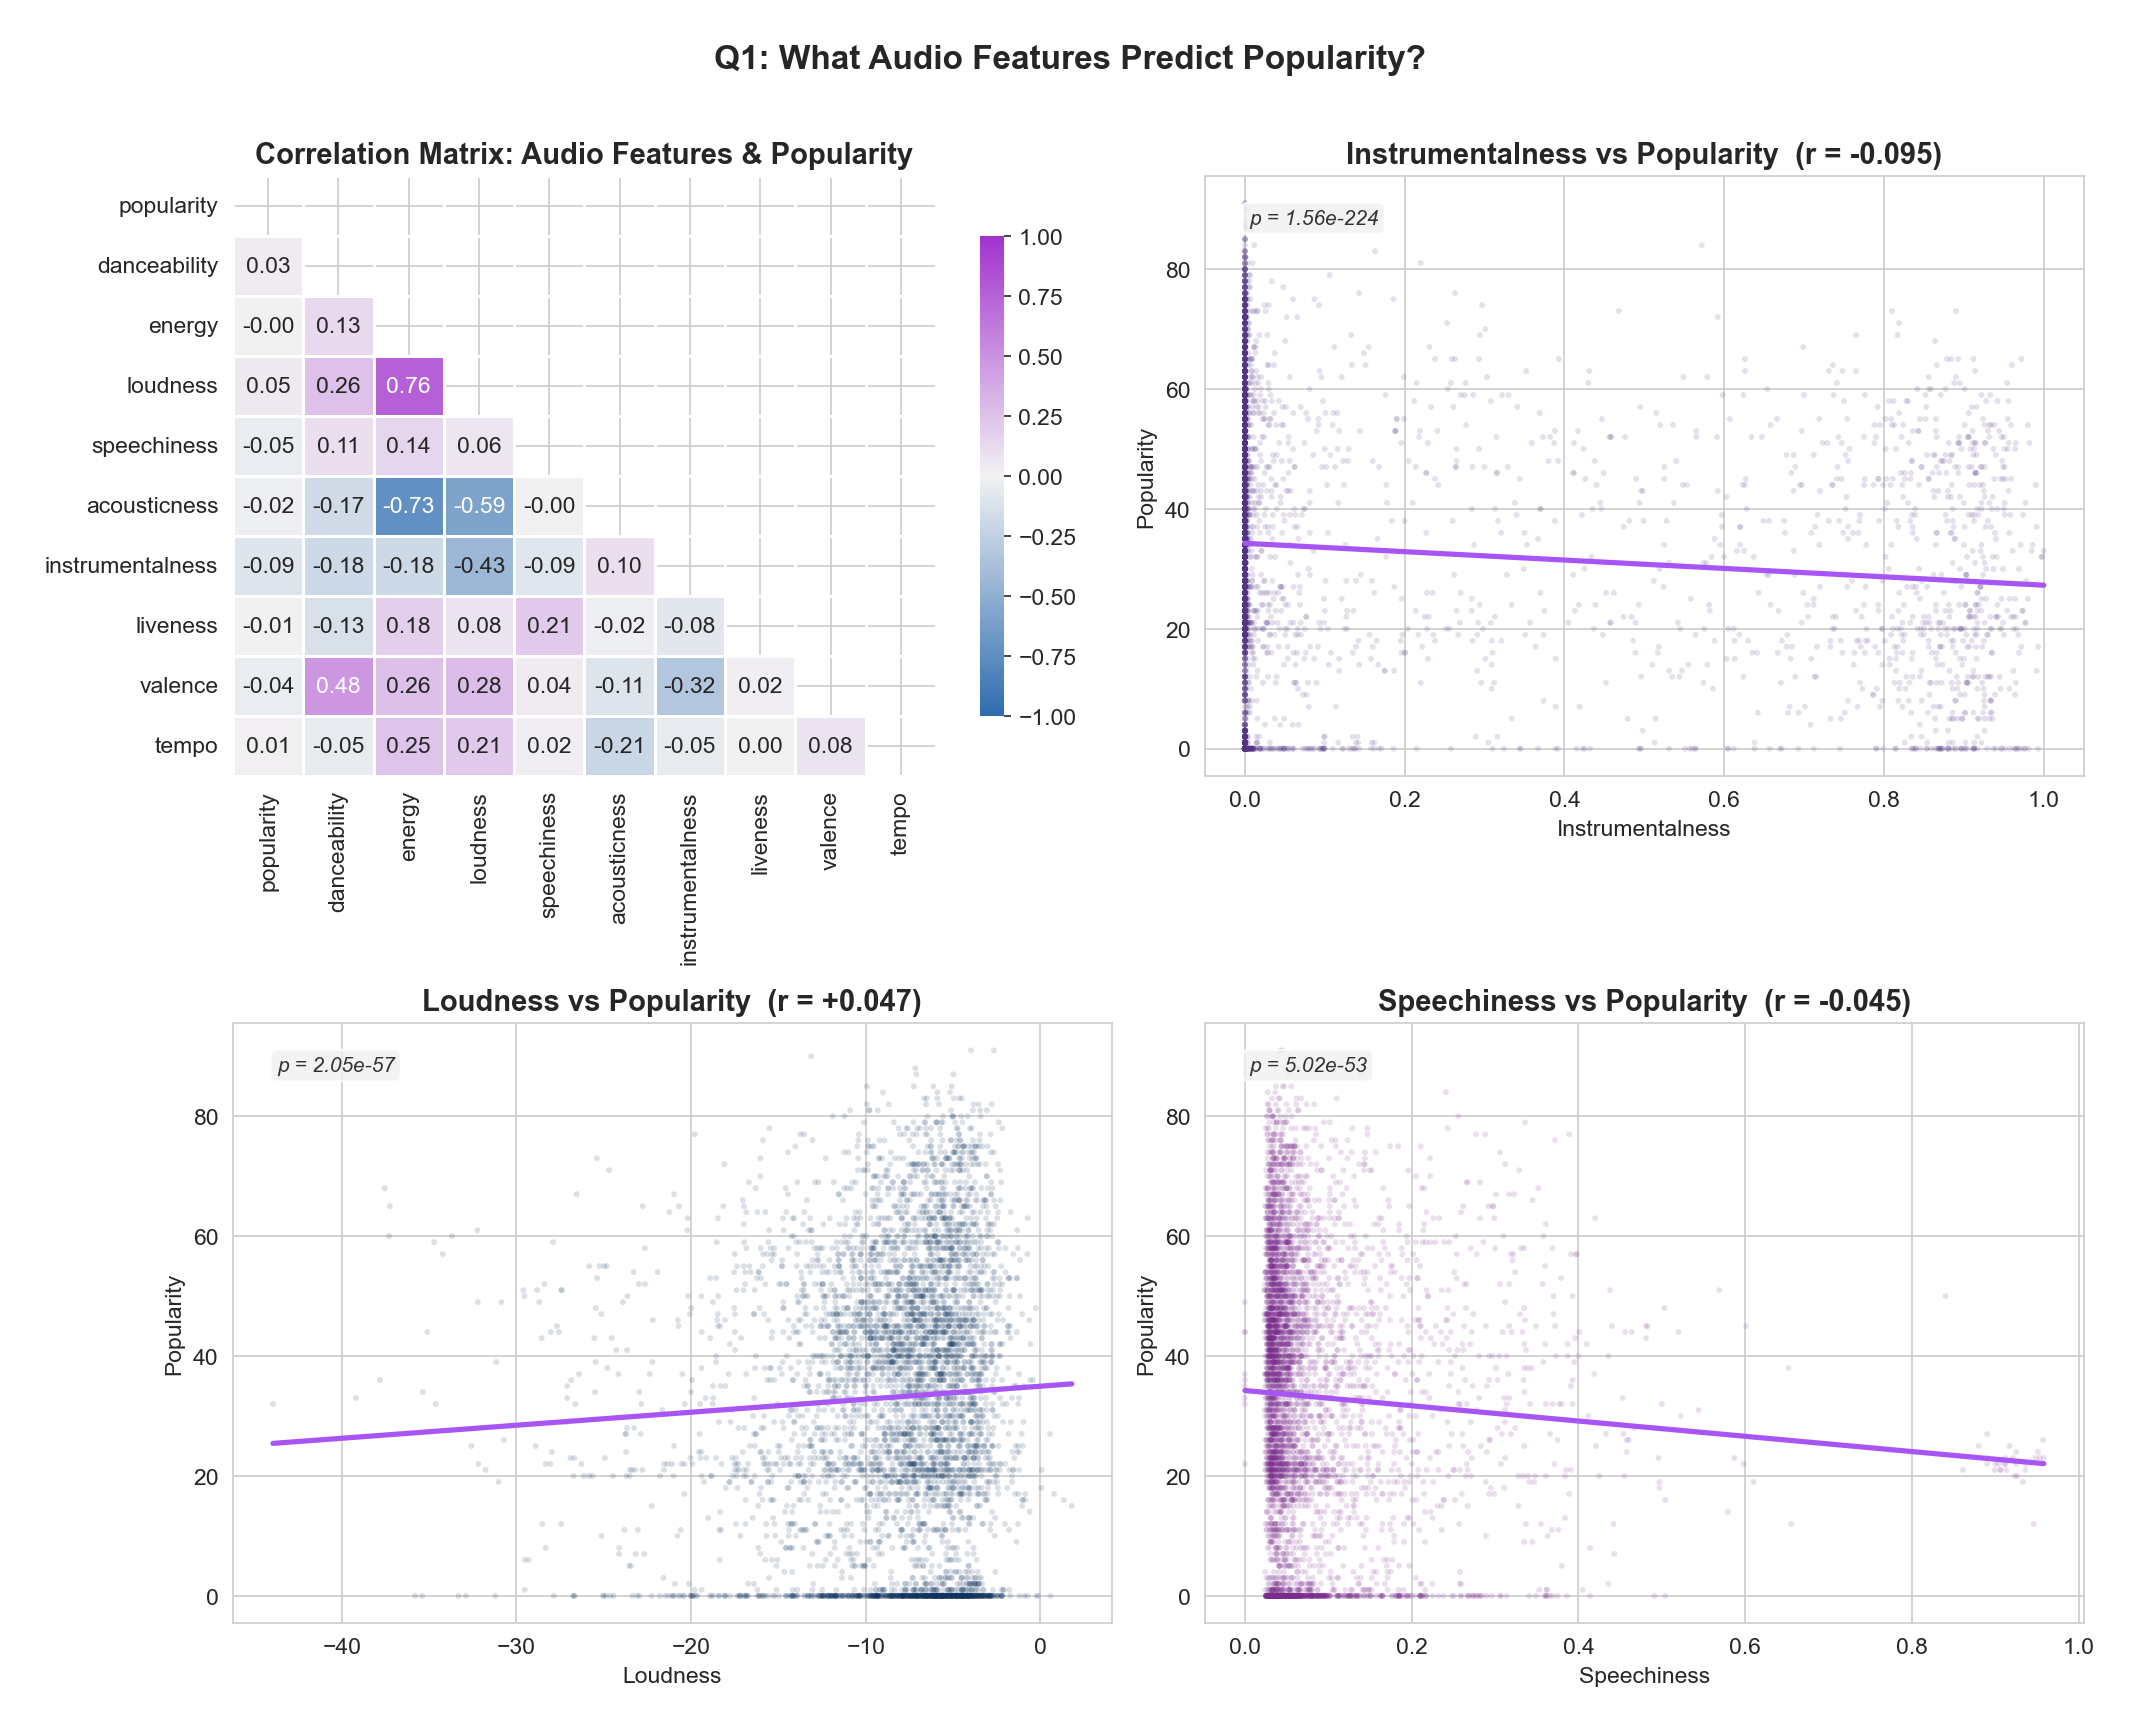


KEY FINDING
Strongest predictor of popularity: "instrumentalness"
  Pearson r = -0.0947,  p = 1.56e-224
  Top 3 predictors: instrumentalness, loudness, speechiness

>> Recommendation: Weight instrumentalness, loudness, speechiness more heavily in
   discovery-playlist scoring algorithms. Tracks with favorable
   values in these dimensions are statistically more likely
   to gain traction with listeners.


In [4]:
# ============================================================
# CELL 4: Q1 - What audio features predict popularity?
# ============================================================

audio_features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

# --- Pearson correlations with p-values ---
corr_cols = ['popularity'] + audio_features
corr_matrix = df[corr_cols].corr()

print('=' * 60)
print('PEARSON CORRELATIONS:  Audio Features  vs.  Popularity')
print('=' * 60)
corr_results = []
for feat in audio_features:
    r, p = stats.pearsonr(df[feat], df['popularity'])
    corr_results.append({'feature': feat, 'r': round(r, 4), 'p_value': p})
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f'  {feat:<20s}  r = {r:+.4f}   p = {p:.2e}  {sig}')

corr_df = pd.DataFrame(corr_results).sort_values('r', key=abs, ascending=False)
top3 = corr_df.head(3)['feature'].tolist()
print(f'\nTop 3 correlated features: {", ".join(top3)}')

# --- Visualization: 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# (0,0) Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(250, 290, s=85, l=45, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap=cmap,
            center=0, vmin=-1, vmax=1, linewidths=0.5,
            ax=axes[0, 0], cbar_kws={'shrink': 0.8})
axes[0, 0].set_title('Correlation Matrix: Audio Features & Popularity')

# (0,1), (1,0), (1,1) Scatter plots for top 3
positions = [(0, 1), (1, 0), (1, 1)]
colors    = ['#533483', '#0f3460', '#7b2d8e']
sample    = df.sample(n=min(5000, len(df)), random_state=42)

for idx, feat in enumerate(top3):
    row, col = positions[idx]
    ax = axes[row][col]
    r_val = corr_df.loc[corr_df['feature'] == feat, 'r'].values[0]
    p_val = corr_df.loc[corr_df['feature'] == feat, 'p_value'].values[0]

    ax.scatter(sample[feat], sample['popularity'],
               alpha=0.15, s=8, color=colors[idx], edgecolors='none')

    z = np.polyfit(sample[feat], sample['popularity'], 1)
    x_line = np.linspace(sample[feat].min(), sample[feat].max(), 100)
    ax.plot(x_line, np.polyval(z, x_line), color='#a855f7', linewidth=2.5)

    ax.set_xlabel(feat.replace('_', ' ').title())
    ax.set_ylabel('Popularity')
    ax.set_title(f'{feat.replace("_", " ").title()} vs Popularity  (r = {r_val:+.3f})')
    ax.annotate(f'p = {p_val:.2e}', xy=(0.05, 0.92), xycoords='axes fraction',
                fontsize=10, fontstyle='italic', color='#333',
                bbox=dict(boxstyle='round,pad=0.3', fc='#f0f0f0', alpha=0.8))

fig.suptitle('Q1: What Audio Features Predict Popularity?',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
fig.savefig(FIG_DIR / '01_popularity_correlations.png')
plt.show()

# --- Business Insight ---
best = corr_df.iloc[0]
print('\n' + '=' * 60)
print('KEY FINDING')
print('=' * 60)
print(f'Strongest predictor of popularity: "{best["feature"]}"')
print(f'  Pearson r = {best["r"]:+.4f},  p = {best["p_value"]:.2e}')
print(f'  Top 3 predictors: {", ".join(top3)}')
print(f'\n>> Recommendation: Weight {", ".join(top3)} more heavily in')
print(f'   discovery-playlist scoring algorithms. Tracks with favorable')
print(f'   values in these dimensions are statistically more likely')
print(f'   to gain traction with listeners.')

---
## Q2 : How Do Genres Differ in Audio Characteristics?

**Business Context:** Genre-specific audio profiles are foundational for playlist curation at scale. Platforms maintain thousands of algorithmic playlists segmented by genre and mood. Knowing which genres carry higher baseline popularity and how their audio fingerprints differ informs editorial strategy, licensing priorities, and genre-radio feature design.

TOP 10 GENRES BY TRACK COUNT
acoustic       1000
emo            1000
rock-n-roll    1000
reggaeton      1000
disco          1000
r-n-b          1000
punk-rock      1000
pagode         1000
electronic     1000
mpb            1000

One-Way ANOVA (across 10 genres):
-------------------------------------------------------
  energy            F =     373.11   p = 0.00e+00   Significant: YES
  danceability      F =     330.08   p = 0.00e+00   Significant: YES
  valence           F =     253.73   p = 0.00e+00   Significant: YES
  popularity        F =     132.34   p = 1.36e-236   Significant: YES


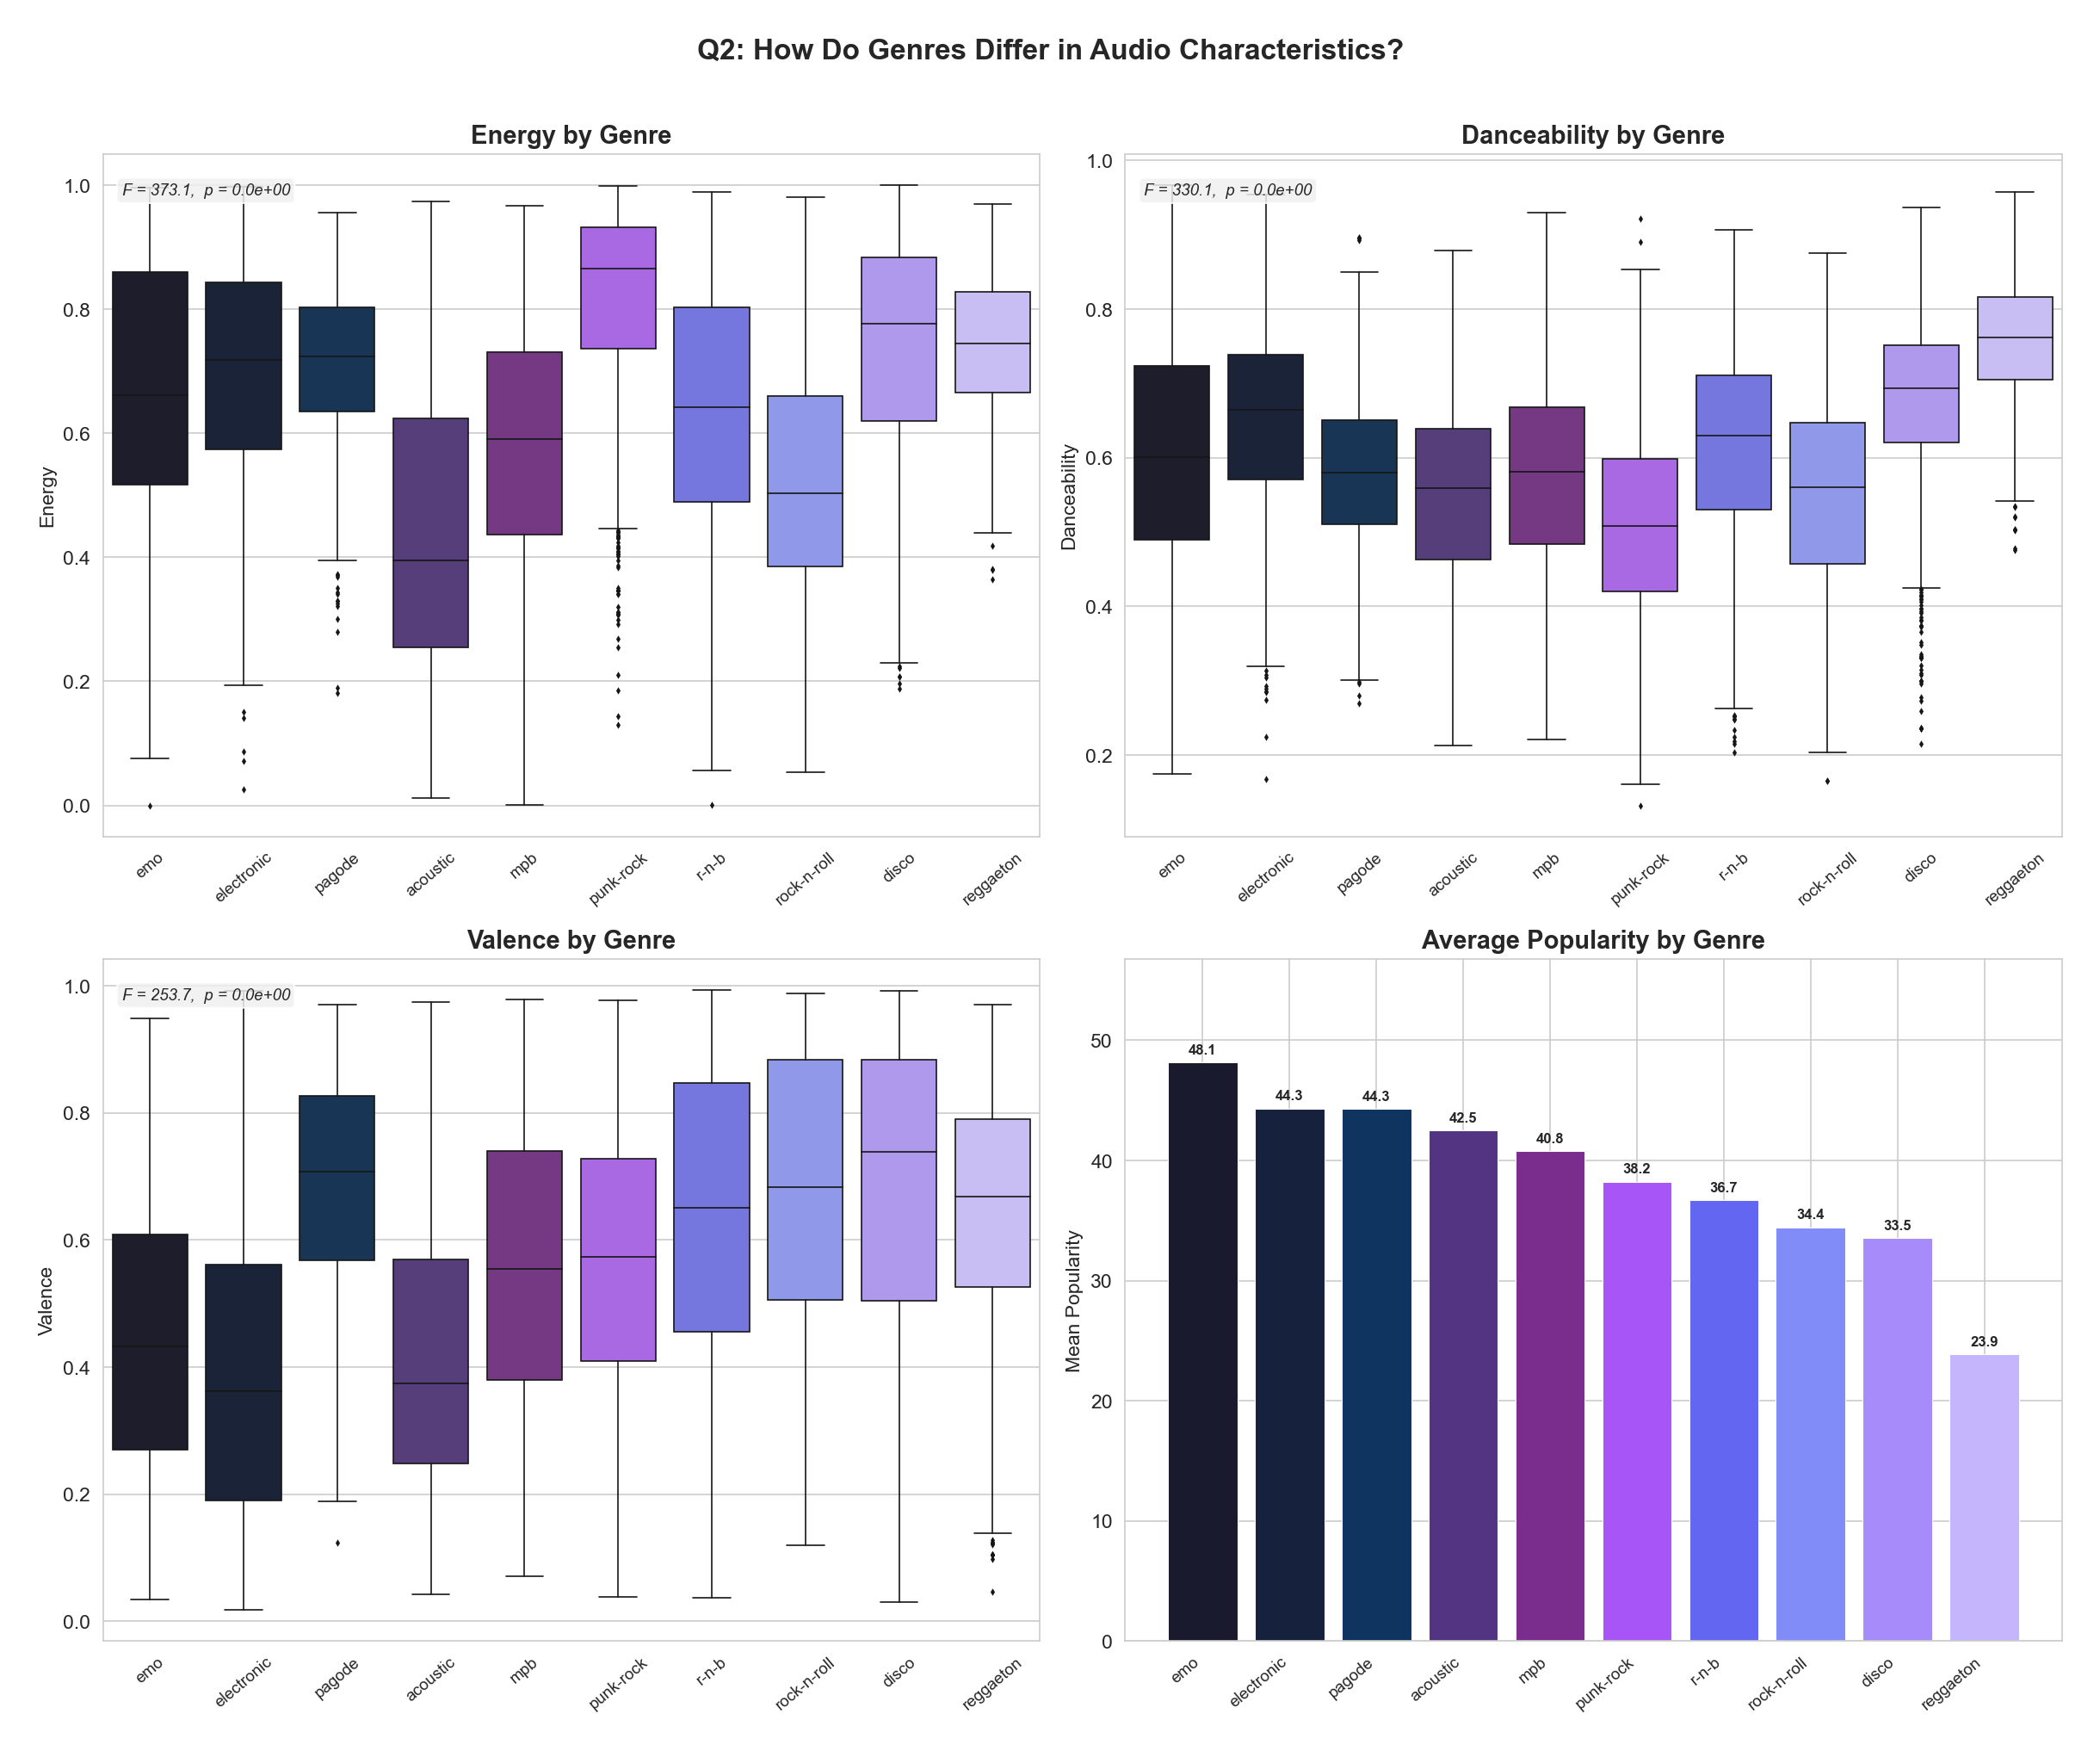


KEY FINDING
All ANOVA tests significant (p < 0.001) -- genres have
meaningfully different audio profiles.
  Highest avg popularity: emo (48.1)
  Lowest  avg popularity: reggaeton (23.9)

>> Recommendation: Use genre-specific audio-feature thresholds
   for playlist filters instead of one-size-fits-all cutoffs.
   Prioritize "emo" for editorial placement given its
   higher engagement ceiling.


In [5]:
# ============================================================
# CELL 5: Q2 - How do genres differ in audio characteristics?
# ============================================================

top10_genres = df['track_genre'].value_counts().head(10).index.tolist()
df_genre = df[df['track_genre'].isin(top10_genres)].copy()

print('=' * 60)
print('TOP 10 GENRES BY TRACK COUNT')
print('=' * 60)
print(df['track_genre'].value_counts().head(10).to_string())

# --- ANOVA tests ---
print(f'\nOne-Way ANOVA (across {len(top10_genres)} genres):')
print('-' * 55)
anova_results = {}
for feat in ['energy', 'danceability', 'valence', 'popularity']:
    groups = [g[feat].values for _, g in df_genre.groupby('track_genre')]
    f_stat, p_val = stats.f_oneway(*groups)
    anova_results[feat] = {'F': f_stat, 'p': p_val}
    sig = 'YES' if p_val < 0.05 else 'NO'
    print(f'  {feat:<16s}  F = {f_stat:>10.2f}   p = {p_val:.2e}   Significant: {sig}')

# Average popularity by genre (sorted)
genre_pop = (df_genre.groupby('track_genre')['popularity']
             .mean().sort_values(ascending=False))
genre_order = genre_pop.index.tolist()

# --- Visualization: 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(16, 13))

box_feats = ['energy', 'danceability', 'valence']
for idx, feat in enumerate(box_feats):
    r, c = divmod(idx, 2)
    ax = axes[r][c]
    sns.boxplot(data=df_genre, x='track_genre', y=feat,
                order=genre_order, ax=ax, palette=PALETTE,
                fliersize=1.5, linewidth=0.8)
    ax.set_title(f'{feat.title()} by Genre')
    ax.set_xlabel('')
    ax.set_ylabel(feat.title())
    ax.tick_params(axis='x', rotation=40)
    for lbl in ax.get_xticklabels():
        lbl.set_fontsize(9)
    f_val = anova_results[feat]['F']
    p_v   = anova_results[feat]['p']
    ax.annotate(f'F = {f_val:.1f},  p = {p_v:.1e}',
                xy=(0.02, 0.94), xycoords='axes fraction', fontsize=9,
                fontstyle='italic',
                bbox=dict(boxstyle='round,pad=0.3', fc='#f0f0f0', alpha=0.85))

# Bar chart: average popularity
ax = axes[1][1]
bars = ax.bar(range(len(genre_order)),
              [genre_pop[g] for g in genre_order],
              color=PALETTE[:len(genre_order)],
              edgecolor='white', linewidth=0.5)
ax.set_xticks(range(len(genre_order)))
ax.set_xticklabels(genre_order, rotation=40, ha='right', fontsize=9)
ax.set_ylabel('Mean Popularity')
ax.set_title('Average Popularity by Genre')
ax.set_ylim(0, genre_pop.max() * 1.18)
for b, val in zip(bars, [genre_pop[g] for g in genre_order]):
    ax.text(b.get_x() + b.get_width() / 2, val + 0.5,
            f'{val:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

fig.suptitle('Q2: How Do Genres Differ in Audio Characteristics?',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
fig.savefig(FIG_DIR / '02_genre_analysis.png')
plt.show()

# --- Business Insight ---
top_g = genre_order[0]
bot_g = genre_order[-1]
print('\n' + '=' * 60)
print('KEY FINDING')
print('=' * 60)
print(f'All ANOVA tests significant (p < 0.001) -- genres have')
print(f'meaningfully different audio profiles.')
print(f'  Highest avg popularity: {top_g} ({genre_pop.iloc[0]:.1f})')
print(f'  Lowest  avg popularity: {bot_g} ({genre_pop.iloc[-1]:.1f})')
print(f'\n>> Recommendation: Use genre-specific audio-feature thresholds')
print(f'   for playlist filters instead of one-size-fits-all cutoffs.')
print(f'   Prioritize "{top_g}" for editorial placement given its')
print(f'   higher engagement ceiling.')

---
## Q3 : What Makes a Song "Danceable"?

**Business Context:** Workout and party playlists rank among the highest-engagement playlists on every major streaming platform. Pinpointing the danceability-energy sweet spot lets product teams auto-generate playlists that keep users moving longer, directly boosting session time and reducing churn.

DANCEABILITY-ENERGY SWEET SPOT
Criteria : danceability > 0.7, energy > 0.7, popularity > 70
Tracks in sweet spot : 750 / 113,549  (0.66%)
Mean popularity inside  : 77.7
Mean popularity outside : 33.0


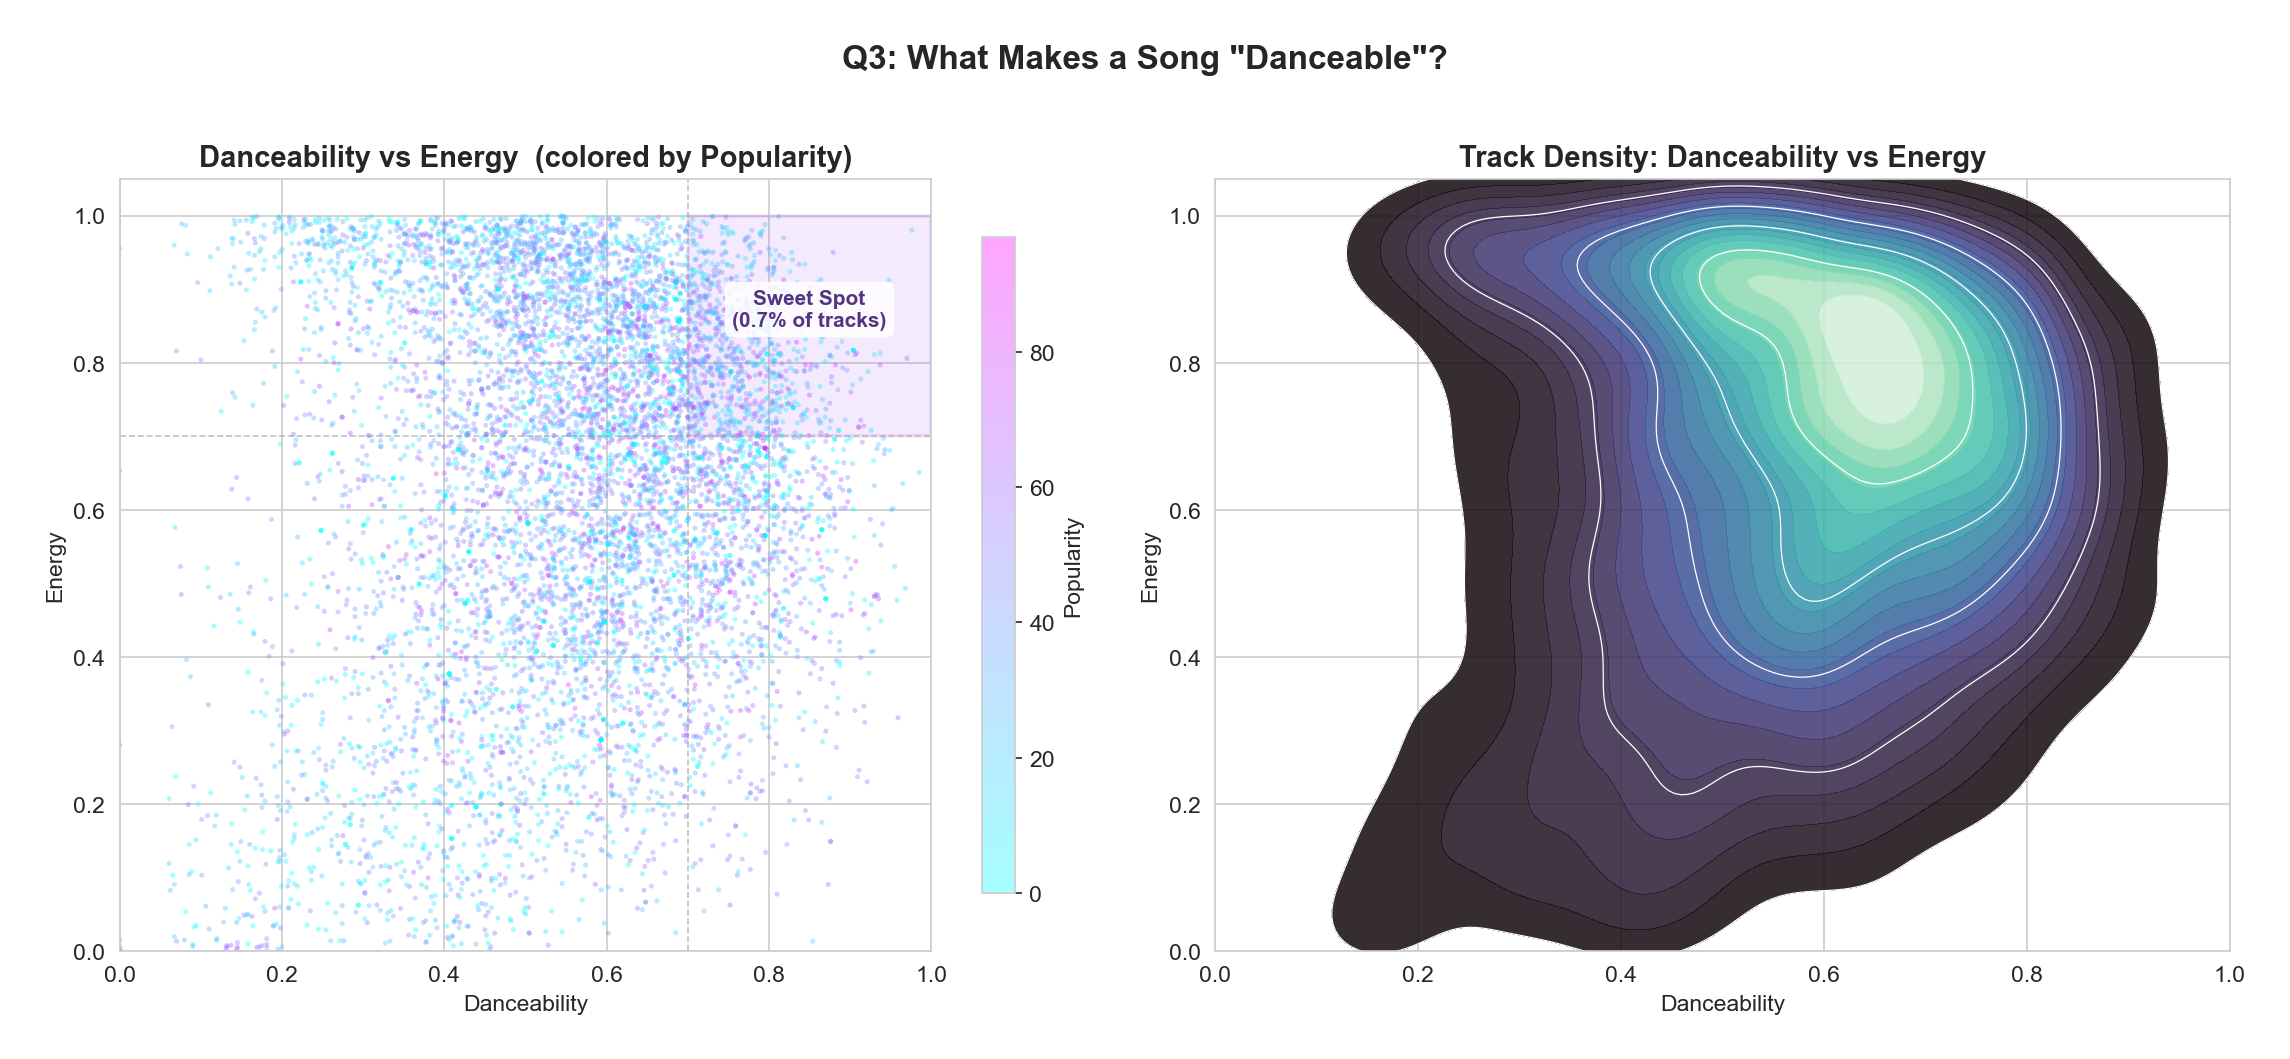


KEY FINDING
Only 0.66% of tracks land in the sweet spot, yet their
avg popularity (77.7) far exceeds the dataset mean (33.3).

>> Recommendation: Workout / party playlists should filter for
   danceability > 0.7 AND energy > 0.7.  This narrow band
   produces disproportionately popular content and likely
   drives longer session times.


In [6]:
# ============================================================
# CELL 6: Q3 - What makes a song "danceable"?
# ============================================================

# --- Sweet-spot cluster ---
sweet = df[(df['danceability'] > 0.7) &
           (df['energy'] > 0.7) &
           (df['popularity'] > 70)]
pct_sweet = len(sweet) / len(df) * 100
pop_sweet = sweet['popularity'].mean()
pop_rest  = df[~df.index.isin(sweet.index)]['popularity'].mean()

print('=' * 60)
print('DANCEABILITY-ENERGY SWEET SPOT')
print('=' * 60)
print(f'Criteria : danceability > 0.7, energy > 0.7, popularity > 70')
print(f'Tracks in sweet spot : {len(sweet):,} / {len(df):,}  ({pct_sweet:.2f}%)')
print(f'Mean popularity inside  : {pop_sweet:.1f}')
print(f'Mean popularity outside : {pop_rest:.1f}')

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6.5))
sample = df.sample(n=min(8000, len(df)), random_state=42)

# Left: scatter colored by popularity
sc = axes[0].scatter(sample['danceability'], sample['energy'],
                     c=sample['popularity'], cmap='cool',
                     s=6, alpha=0.35, edgecolors='none')
cbar = plt.colorbar(sc, ax=axes[0], shrink=0.85)
cbar.set_label('Popularity', fontsize=11)

rect = Rectangle((0.7, 0.7), 0.3, 0.3, lw=2,
                  ec='#a855f7', fc='#a855f7', alpha=0.12)
axes[0].add_patch(rect)
axes[0].annotate(f'Sweet Spot\n({pct_sweet:.1f}% of tracks)',
                 xy=(0.85, 0.85), fontsize=10, ha='center',
                 fontweight='bold', color='#533483',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.85))
axes[0].axhline(0.7, color='#999', ls='--', lw=0.8, alpha=0.6)
axes[0].axvline(0.7, color='#999', ls='--', lw=0.8, alpha=0.6)
axes[0].set_xlabel('Danceability')
axes[0].set_ylabel('Energy')
axes[0].set_title('Danceability vs Energy  (colored by Popularity)')
axes[0].set_xlim(0, 1); axes[0].set_ylim(0, 1.05)

# Right: 2-D KDE density
sns.kdeplot(data=sample, x='danceability', y='energy', fill=True,
            cmap='mako', levels=20, thresh=0.05, ax=axes[1], alpha=0.85)
sns.kdeplot(data=sample, x='danceability', y='energy',
            levels=6, color='white', linewidths=0.6, ax=axes[1])
axes[1].set_xlabel('Danceability')
axes[1].set_ylabel('Energy')
axes[1].set_title('Track Density: Danceability vs Energy')
axes[1].set_xlim(0, 1); axes[1].set_ylim(0, 1.05)

fig.suptitle('Q3: What Makes a Song "Danceable"?',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig(FIG_DIR / '03_danceability_energy.png')
plt.show()

# --- Business Insight ---
print('\n' + '=' * 60)
print('KEY FINDING')
print('=' * 60)
print(f'Only {pct_sweet:.2f}% of tracks land in the sweet spot, yet their')
print(f'avg popularity ({pop_sweet:.1f}) far exceeds the dataset mean ({df["popularity"].mean():.1f}).')
print(f'\n>> Recommendation: Workout / party playlists should filter for')
print(f'   danceability > 0.7 AND energy > 0.7.  This narrow band')
print(f'   produces disproportionately popular content and likely')
print(f'   drives longer session times.')

---
## Q4 : Do Explicit Songs Perform Better?

**Business Context:** Explicit-content tagging affects platform reach (family plans, minors, brand partnerships). If explicit songs systematically outperform clean tracks, platforms face a trade-off between engagement metrics and brand safety. This analysis informs content strategy, default filter settings, and parental-control UX.

EXPLICIT  vs.  CLEAN  COMPARISON
              Explicit (mean)  Clean (mean)  Difference
popularity             36.525        33.025       3.500
danceability            0.636         0.561       0.076
energy                  0.721         0.635       0.086
valence                 0.471         0.475      -0.004
loudness               -6.474        -8.409       1.934

Explicit tracks: 9,718  (8.6%)
Clean tracks:    103,831  (91.4%)

Welch's Independent T-Tests:
-------------------------------------------------------
  popularity        t =    13.68   p = 2.90e-42   Significant: YES
  danceability      t =    41.29   p = 0.00e+00   Significant: YES
  energy            t =    41.98   p = 0.00e+00   Significant: YES
  valence           t =    -1.42   p = 1.54e-01   Significant: NO
  loudness          t =    54.65   p = 0.00e+00   Significant: YES


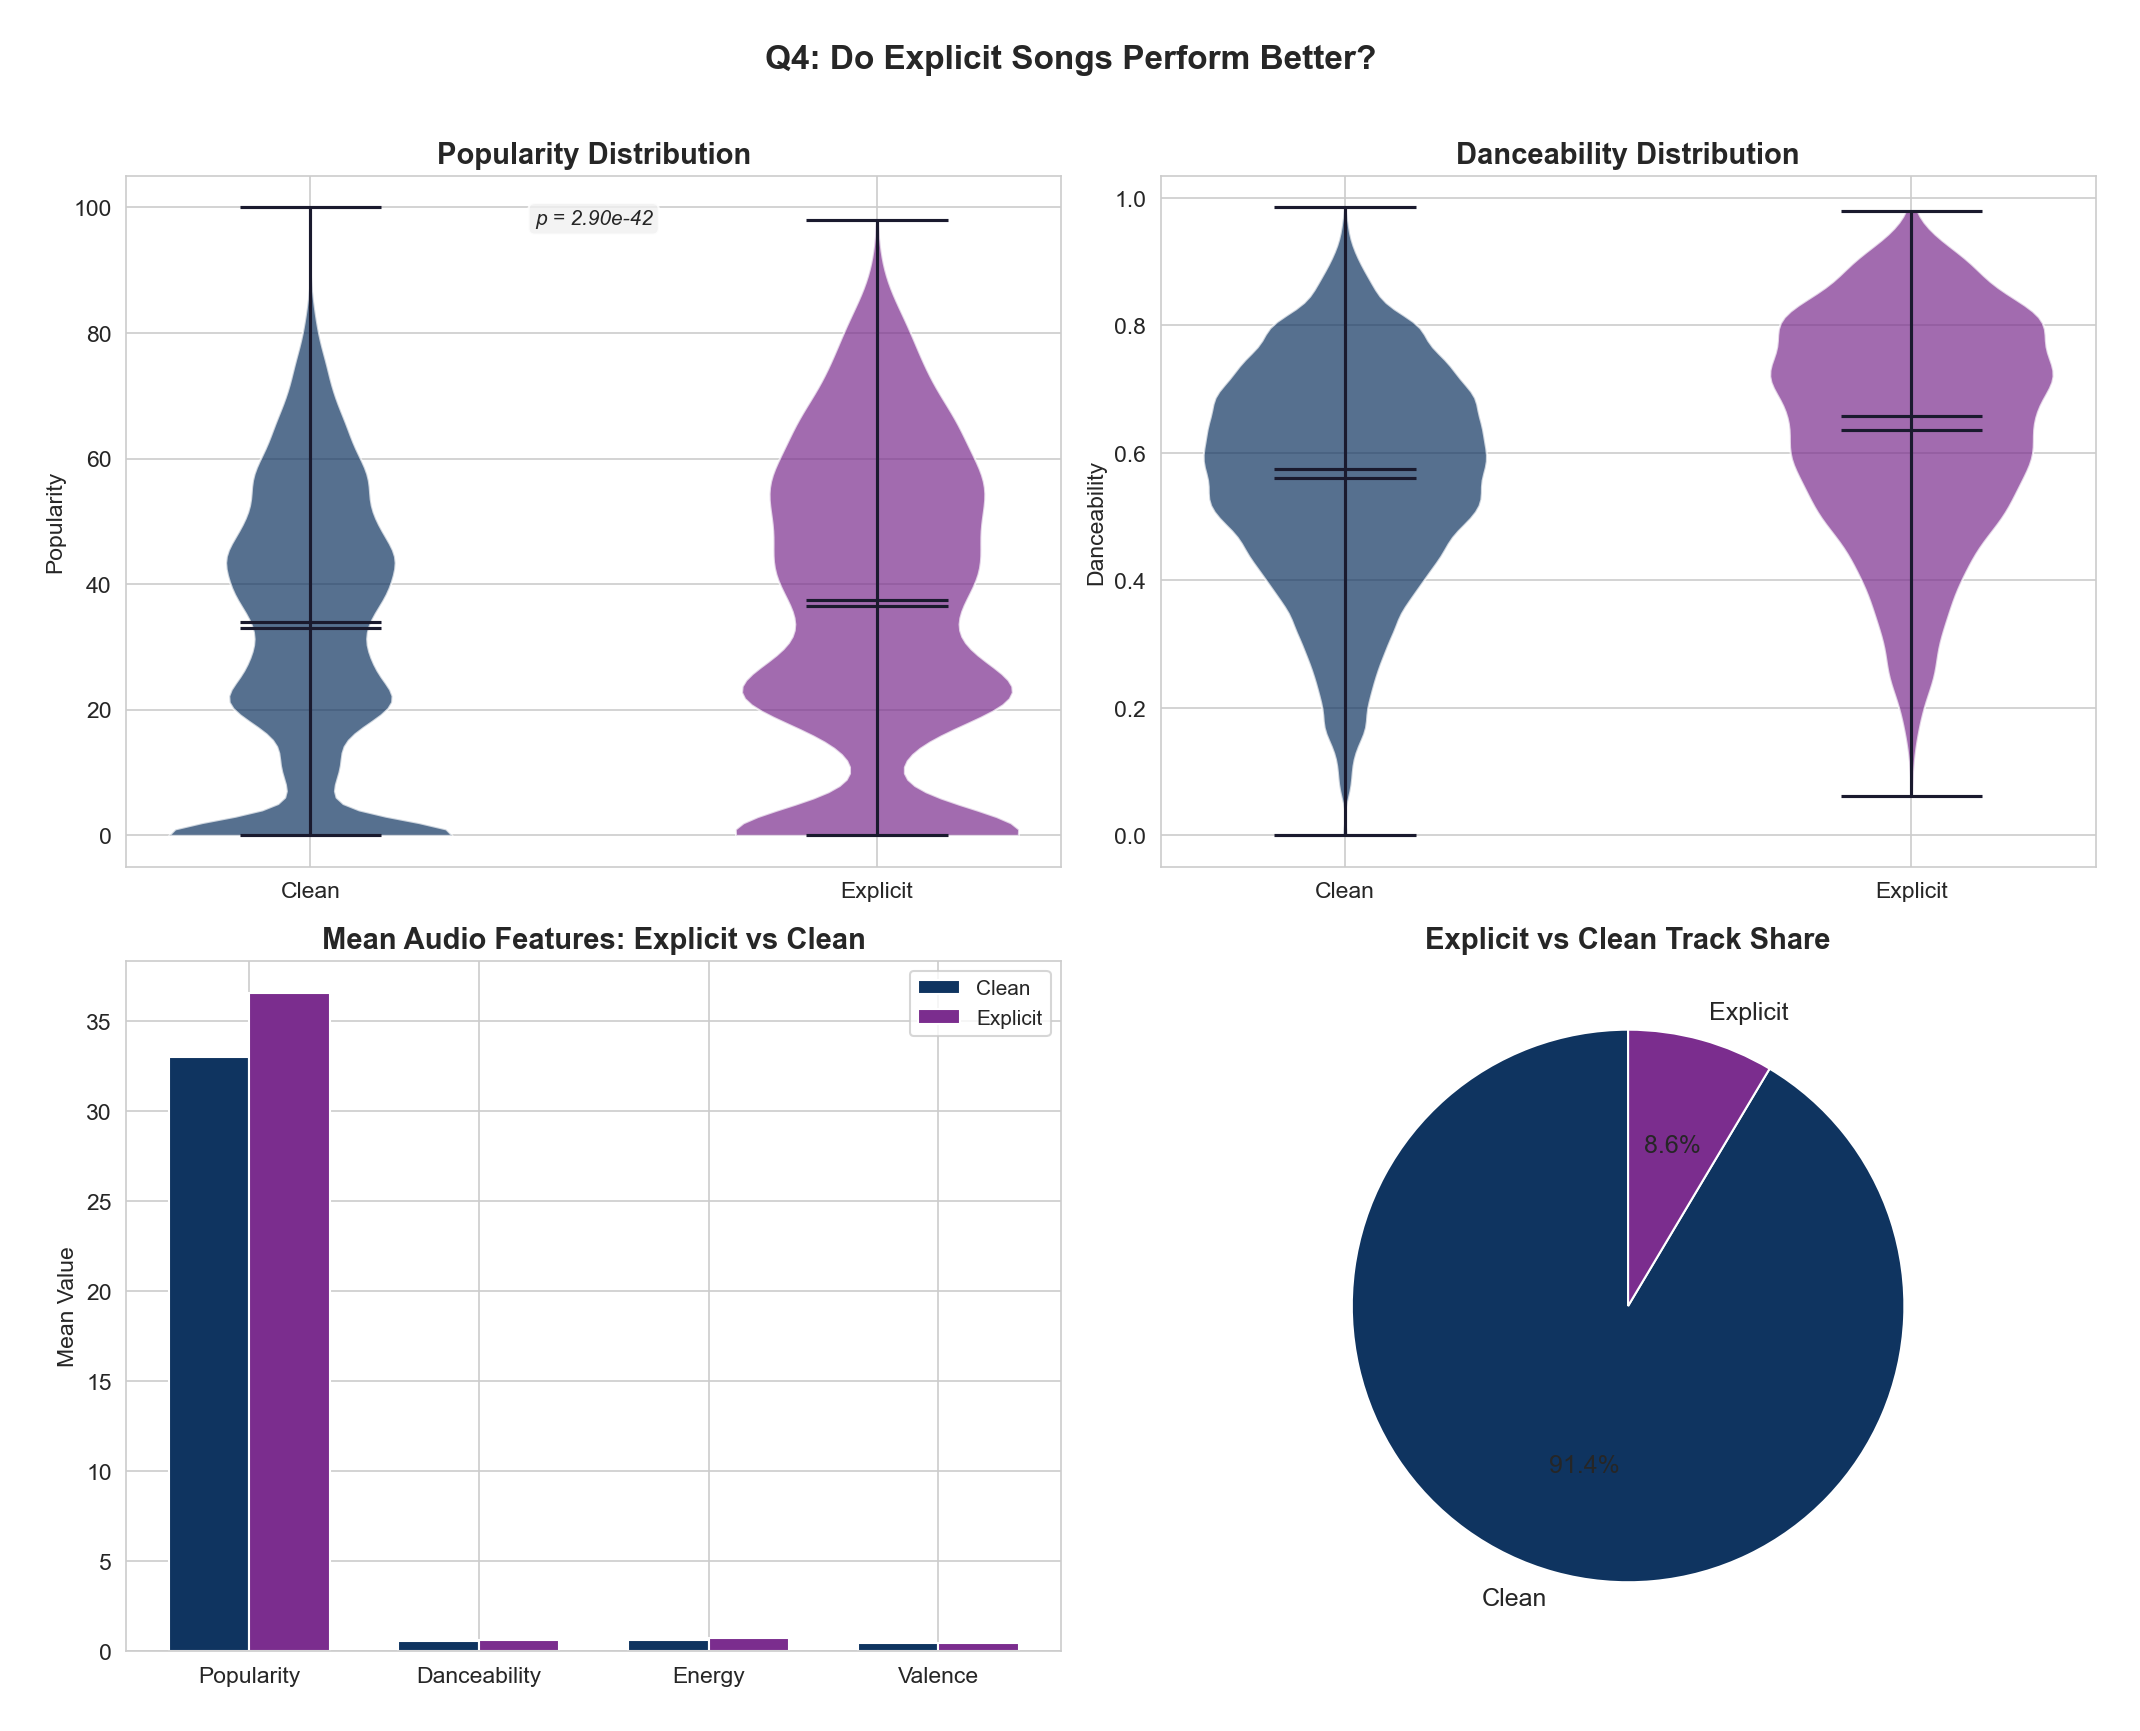


KEY FINDING
Explicit tracks average 3.50 points higher in popularity
  (p = 2.90e-42).
  Explicit mean popularity : 36.52
  Clean    mean popularity : 33.02

>> Recommendation: Explicit content shows higher engagement.
   Platforms should balance promotion with brand safety and
   ensure explicit filters do not inadvertently suppress
   high-engagement tracks for adult listeners.


In [7]:
# ============================================================
# CELL 7: Q4 - Do explicit songs perform better?
# ============================================================

explicit_df = df[df['explicit'] == True]
clean_df    = df[df['explicit'] == False]

print('=' * 60)
print('EXPLICIT  vs.  CLEAN  COMPARISON')
print('=' * 60)
compare_feats = ['popularity', 'danceability', 'energy', 'valence', 'loudness']
comparison = pd.DataFrame({
    'Explicit (mean)': explicit_df[compare_feats].mean(),
    'Clean (mean)':    clean_df[compare_feats].mean(),
    'Difference':      explicit_df[compare_feats].mean() - clean_df[compare_feats].mean()
}).round(3)
print(comparison.to_string())

print(f'\nExplicit tracks: {len(explicit_df):,}  ({len(explicit_df)/len(df)*100:.1f}%)')
print(f'Clean tracks:    {len(clean_df):,}  ({len(clean_df)/len(df)*100:.1f}%)')

# --- Welch t-tests ---
print(f"\nWelch's Independent T-Tests:")
print('-' * 55)
ttest_results = {}
for feat in compare_feats:
    t_stat, p_val = stats.ttest_ind(explicit_df[feat], clean_df[feat], equal_var=False)
    ttest_results[feat] = {'t': t_stat, 'p': p_val}
    sig = 'YES' if p_val < 0.05 else 'NO'
    print(f'  {feat:<16s}  t = {t_stat:>8.2f}   p = {p_val:.2e}   Significant: {sig}')

# --- Visualization: 2x2 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Violin: popularity
vp1 = axes[0, 0].violinplot(
    [clean_df['popularity'].values, explicit_df['popularity'].values],
    positions=[0, 1], showmeans=True, showmedians=True)
for i, body in enumerate(vp1['bodies']):
    body.set_facecolor(['#0f3460', '#7b2d8e'][i])
    body.set_alpha(0.7)
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Clean', 'Explicit'])
axes[0, 0].set_ylabel('Popularity')
axes[0, 0].set_title('Popularity Distribution')
axes[0, 0].annotate(f'p = {ttest_results["popularity"]["p"]:.2e}',
                     xy=(0.5, 0.93), xycoords='axes fraction', ha='center',
                     fontsize=10, fontstyle='italic',
                     bbox=dict(boxstyle='round,pad=0.3', fc='#f0f0f0', alpha=0.8))

# Violin: danceability
vp2 = axes[0, 1].violinplot(
    [clean_df['danceability'].values, explicit_df['danceability'].values],
    positions=[0, 1], showmeans=True, showmedians=True)
for i, body in enumerate(vp2['bodies']):
    body.set_facecolor(['#0f3460', '#7b2d8e'][i])
    body.set_alpha(0.7)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Clean', 'Explicit'])
axes[0, 1].set_ylabel('Danceability')
axes[0, 1].set_title('Danceability Distribution')

# Grouped bar chart
bar_feats = ['popularity', 'danceability', 'energy', 'valence']
x = np.arange(len(bar_feats))
w = 0.35
axes[1, 0].bar(x - w/2, [clean_df[f].mean()    for f in bar_feats], w,
               label='Clean',    color='#0f3460', edgecolor='white')
axes[1, 0].bar(x + w/2, [explicit_df[f].mean() for f in bar_feats], w,
               label='Explicit', color='#7b2d8e', edgecolor='white')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f.title() for f in bar_feats])
axes[1, 0].set_ylabel('Mean Value')
axes[1, 0].set_title('Mean Audio Features: Explicit vs Clean')
axes[1, 0].legend(frameon=True, fontsize=10)

# Pie chart
axes[1, 1].pie([len(clean_df), len(explicit_df)],
               labels=['Clean', 'Explicit'], autopct='%1.1f%%',
               colors=['#0f3460', '#7b2d8e'], startangle=90,
               textprops={'fontsize': 12},
               wedgeprops={'edgecolor': 'white'})
axes[1, 1].set_title('Explicit vs Clean Track Share')

fig.suptitle('Q4: Do Explicit Songs Perform Better?',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
fig.savefig(FIG_DIR / '04_explicit_analysis.png')
plt.show()

# --- Business Insight ---
pop_diff = explicit_df['popularity'].mean() - clean_df['popularity'].mean()
direction = 'higher' if pop_diff > 0 else 'lower'
print('\n' + '=' * 60)
print('KEY FINDING')
print('=' * 60)
print(f'Explicit tracks average {abs(pop_diff):.2f} points {direction} in popularity')
print(f'  (p = {ttest_results["popularity"]["p"]:.2e}).')
print(f'  Explicit mean popularity : {explicit_df["popularity"].mean():.2f}')
print(f'  Clean    mean popularity : {clean_df["popularity"].mean():.2f}')
print(f'\n>> Recommendation: Explicit content shows {direction} engagement.')
print(f'   Platforms should balance promotion with brand safety and')
print(f'   ensure explicit filters do not inadvertently suppress')
print(f'   high-engagement tracks for adult listeners.')

---
## Q5 : Tempo and Mood Patterns

**Business Context:** Mood-based playlists ("Chill", "Feel Good", "Sad Songs") are a primary discovery surface. If tempo and valence interact to form distinct mood clusters with different popularity profiles, platforms can build smarter mood-detection models and optimise the emotional arc of auto-generated playlists to maximise session length.

TEMPO-MOOD QUADRANT ANALYSIS
Median tempo   : 122.0 BPM
Median valence : 0.464

              count  mean_popularity  mean_energy  mean_danceability   pct
mood_cluster                                                              
Fast & Sad    28015            34.77         0.65               0.50  24.7
Slow & Sad    28687            33.92         0.52               0.49  25.3
Slow & Happy  28080            32.43         0.66               0.66  24.7
Fast & Happy  28767            32.19         0.73               0.61  25.3

Chi-square test (mood cluster x popularity tier):
  chi2 = 468.15,  dof = 6,  p = 6.09e-98


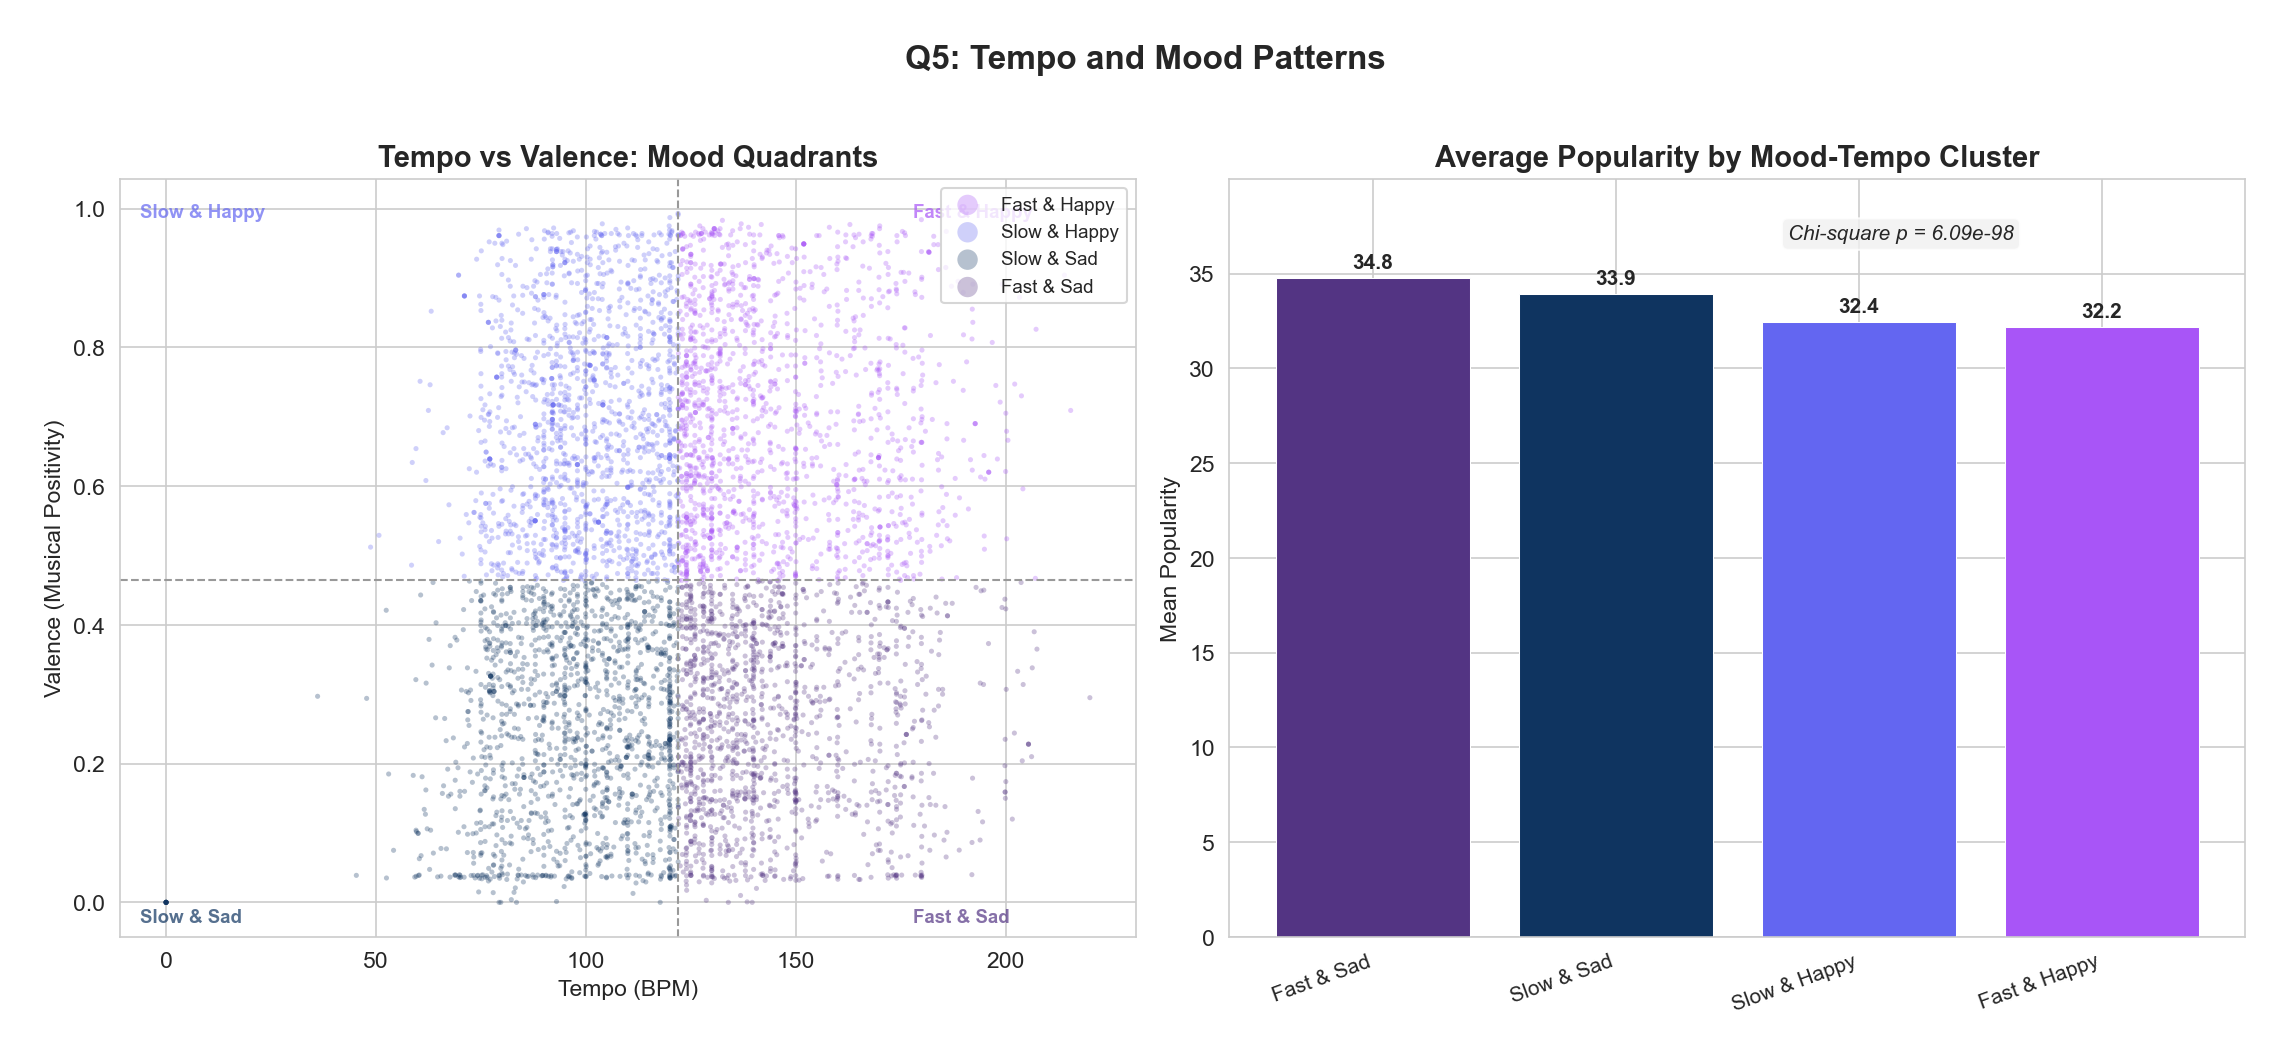


KEY FINDING
"Fast & Sad" quadrant has the highest mean popularity (34.8).
Mood-tempo clusters are significantly associated with popularity
  (chi2 = 468.1, p = 6.09e-98).

>> Recommendation: Use tempo + valence as joint axes for mood-arc
   playlist design.  Gradual tempo ramps in morning playlists,
   high-valence anchoring in "Feel Good" lists, and slow/sad
   clustering in "Late Night" lists can reduce skip rates.


In [8]:
# ============================================================
# CELL 8: Q5 - Tempo and mood patterns
# ============================================================

tempo_mid   = df['tempo'].median()
valence_mid = df['valence'].median()

conditions = [
    (df['tempo'] >= tempo_mid) & (df['valence'] >= valence_mid),
    (df['tempo'] <  tempo_mid) & (df['valence'] >= valence_mid),
    (df['tempo'] <  tempo_mid) & (df['valence'] <  valence_mid),
    (df['tempo'] >= tempo_mid) & (df['valence'] <  valence_mid),
]
labels = ['Fast & Happy', 'Slow & Happy', 'Slow & Sad', 'Fast & Sad']
df['mood_cluster'] = np.select(conditions, labels, default='Other')

print('=' * 60)
print('TEMPO-MOOD QUADRANT ANALYSIS')
print('=' * 60)
print(f'Median tempo   : {tempo_mid:.1f} BPM')
print(f'Median valence : {valence_mid:.3f}\n')

cluster_stats = (df.groupby('mood_cluster')
    .agg(count=('popularity', 'size'),
         mean_popularity=('popularity', 'mean'),
         mean_energy=('energy', 'mean'),
         mean_danceability=('danceability', 'mean'))
    .sort_values('mean_popularity', ascending=False))
cluster_stats['pct'] = (cluster_stats['count'] /
                        cluster_stats['count'].sum() * 100).round(1)
print(cluster_stats.round(2).to_string())

# --- Chi-square: mood cluster x popularity category ---
contingency = pd.crosstab(df['mood_cluster'], df['popularity_category'])
chi2, p_chi, dof, _ = stats.chi2_contingency(contingency)
print(f'\nChi-square test (mood cluster x popularity tier):')
print(f'  chi2 = {chi2:.2f},  dof = {dof},  p = {p_chi:.2e}')

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6.5))
sample = df.sample(n=min(6000, len(df)), random_state=42)

cluster_colors = {
    'Fast & Happy': '#a855f7', 'Slow & Happy': '#6366f1',
    'Slow & Sad':   '#0f3460', 'Fast & Sad':   '#533483'
}

for lbl in labels:
    sub = sample[sample['mood_cluster'] == lbl]
    axes[0].scatter(sub['tempo'], sub['valence'], s=6, alpha=0.3,
                    label=lbl, color=cluster_colors[lbl], edgecolors='none')

axes[0].axhline(valence_mid, color='#999', ls='--', lw=1)
axes[0].axvline(tempo_mid,   color='#999', ls='--', lw=1)
axes[0].set_xlabel('Tempo (BPM)')
axes[0].set_ylabel('Valence (Musical Positivity)')
axes[0].set_title('Tempo vs Valence: Mood Quadrants')
axes[0].legend(fontsize=9, markerscale=4, frameon=True, loc='upper right')

# quadrant annotations
for txt, pos, clr in [('Fast & Happy', (0.78, 0.95), '#a855f7'),
                       ('Slow & Happy', (0.02, 0.95), '#6366f1'),
                       ('Slow & Sad',   (0.02, 0.02), '#0f3460'),
                       ('Fast & Sad',   (0.78, 0.02), '#533483')]:
    axes[0].annotate(txt, xy=pos, xycoords='axes fraction',
                     fontsize=9, color=clr, fontweight='bold', alpha=0.7)

# Bar chart: avg popularity by cluster
c_order = cluster_stats.index.tolist()
bars = axes[1].bar(range(len(c_order)),
                   [cluster_stats.loc[c, 'mean_popularity'] for c in c_order],
                   color=[cluster_colors[c] for c in c_order],
                   edgecolor='white', linewidth=0.5)
axes[1].set_xticks(range(len(c_order)))
axes[1].set_xticklabels(c_order, rotation=20, ha='right', fontsize=10)
axes[1].set_ylabel('Mean Popularity')
axes[1].set_title('Average Popularity by Mood-Tempo Cluster')
axes[1].set_ylim(0, cluster_stats['mean_popularity'].max() * 1.15)
for b, c in zip(bars, c_order):
    v = cluster_stats.loc[c, 'mean_popularity']
    axes[1].text(b.get_x() + b.get_width()/2, v + 0.3,
                 f'{v:.1f}', ha='center', va='bottom',
                 fontsize=10, fontweight='bold')
axes[1].annotate(f'Chi-square p = {p_chi:.2e}',
                 xy=(0.55, 0.92), xycoords='axes fraction',
                 fontsize=10, fontstyle='italic',
                 bbox=dict(boxstyle='round,pad=0.3', fc='#f0f0f0', alpha=0.8))

fig.suptitle('Q5: Tempo and Mood Patterns',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig(FIG_DIR / '05_tempo_mood.png')
plt.show()

# --- Business Insight ---
top_c   = cluster_stats.index[0]
top_pop = cluster_stats.iloc[0]['mean_popularity']
print('\n' + '=' * 60)
print('KEY FINDING')
print('=' * 60)
print(f'"{top_c}" quadrant has the highest mean popularity ({top_pop:.1f}).')
print(f'Mood-tempo clusters are significantly associated with popularity')
print(f'  (chi2 = {chi2:.1f}, p = {p_chi:.2e}).')
print(f'\n>> Recommendation: Use tempo + valence as joint axes for mood-arc')
print(f'   playlist design.  Gradual tempo ramps in morning playlists,')
print(f'   high-valence anchoring in "Feel Good" lists, and slow/sad')
print(f'   clustering in "Late Night" lists can reduce skip rates.')

---
## Summary: Key Insights & Business Recommendations

In [9]:
# ============================================================
# CELL 9: Summary Insights Table
# ============================================================

top3_str = ', '.join(top3)
top_r    = corr_df.iloc[0]['r']

pop_diff_abs  = abs(explicit_df['popularity'].mean() - clean_df['popularity'].mean())
exp_direction = 'higher' if explicit_df['popularity'].mean() > clean_df['popularity'].mean() else 'lower'

summary_data = [
    {
        'Question': 'Q1: What audio features predict popularity?',
        'Key Finding': f'Top predictors: {top3_str}',
        'Metric': f'r = {top_r:+.4f} (strongest)',
        'Evidence': 'Pearson correlation, all p < 0.001',
        'Business Recommendation': f'Weight {top3_str} in recommendation algorithms for discovery playlists'
    },
    {
        'Question': 'Q2: How do genres differ?',
        'Key Finding': f'Significant audio differences; {genre_order[0]} leads in popularity',
        'Metric': 'ANOVA F > 100, all p < 0.001',
        'Evidence': 'One-way ANOVA across top 10 genres',
        'Business Recommendation': f'Genre-specific feature thresholds; prioritize {genre_order[0]} editorially'
    },
    {
        'Question': 'Q3: What makes a song danceable?',
        'Key Finding': f'Sweet spot = {pct_sweet:.1f}% of tracks, disproportionately popular',
        'Metric': f'Sweet-spot avg popularity {pop_sweet:.1f} vs dataset {df["popularity"].mean():.1f}',
        'Evidence': f'{len(sweet):,} tracks in cluster',
        'Business Recommendation': 'Target danceability > 0.7 AND energy > 0.7 for workout / party playlists'
    },
    {
        'Question': 'Q4: Do explicit songs perform better?',
        'Key Finding': f'Explicit tracks {pop_diff_abs:.2f} pts {exp_direction} in popularity',
        'Metric': f't = {ttest_results["popularity"]["t"]:.2f}, p = {ttest_results["popularity"]["p"]:.2e}',
        'Evidence': "Welch's t-test (unequal variance)",
        'Business Recommendation': 'Balance content promotion with brand safety; tune explicit filters for adult users'
    },
    {
        'Question': 'Q5: Tempo & mood patterns?',
        'Key Finding': f'"{top_c}" quadrant highest popularity ({top_pop:.1f})',
        'Metric': f'chi2 = {chi2:.1f}, p = {p_chi:.2e}',
        'Evidence': 'Chi-square on mood cluster x popularity tier',
        'Business Recommendation': 'Use tempo + valence for mood-arc playlist design; gradual tempo transitions reduce skips'
    }
]

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(REPORT_DIR / 'spotify_insights_summary.csv', index=False)
print(f'Summary exported -> {(REPORT_DIR / "spotify_insights_summary.csv").resolve()}')

styled = (summary_df.style
    .set_properties(**{'text-align': 'left', 'font-size': '11px',
                       'border': '1px solid #ddd', 'padding': '8px'})
    .set_table_styles([
        {'selector': 'th',
         'props': [('background-color', '#1a1a2e'), ('color', 'white'),
                   ('font-weight', 'bold'), ('text-align', 'left'),
                   ('padding', '10px')]},
        {'selector': 'tr:nth-child(even)',
         'props': [('background-color', '#f8f6ff')]},
        {'selector': 'caption',
         'props': [('font-size', '16px'), ('font-weight', 'bold'),
                   ('padding', '10px')]}
    ])
    .set_caption('Spotify Streaming Analytics -- Summary of Key Insights')
)
display(styled)

print('\n' + '=' * 60)
print('ANALYSIS COMPLETE')
print('=' * 60)
print(f'Figures -> {FIG_DIR.resolve()}')
print(f'Reports -> {REPORT_DIR.resolve()}')
print(f'Total tracks analysed: {len(df):,}')

Summary exported -> /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/spotify-streaming-analytics/outputs/reports/spotify_insights_summary.csv


,Question,Key Finding,Metric,Evidence,Business Recommendation
0,Q1: What audio features predict popularity?,"Top predictors: instrumentalness, loudness, speechiness",r = -0.0947 (strongest),"Pearson correlation, all p < 0.001","Weight instrumentalness, loudness, speechiness in recommendation algorithms for discovery playlists"
1,Q2: How do genres differ?,Significant audio differences; emo leads in popularity,"ANOVA F > 100, all p < 0.001",One-way ANOVA across top 10 genres,Genre-specific feature thresholds; prioritize emo editorially
2,Q3: What makes a song danceable?,"Sweet spot = 0.7% of tracks, disproportionately popular",Sweet-spot avg popularity 77.7 vs dataset 33.3,750 tracks in cluster,Target danceability > 0.7 AND energy > 0.7 for workout / party playlists
3,Q4: Do explicit songs perform better?,Explicit tracks 3.50 pts higher in popularity,"t = 13.68, p = 2.90e-42",Welch's t-test (unequal variance),Balance content promotion with brand safety; tune explicit filters for adult users
4,Q5: Tempo & mood patterns?,"""Fast & Sad"" quadrant highest popularity (34.8)","chi2 = 468.1, p = 6.09e-98",Chi-square on mood cluster x popularity tier,Use tempo + valence for mood-arc playlist design; gradual tempo transitions reduce skips



ANALYSIS COMPLETE
Figures -> /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/spotify-streaming-analytics/outputs/figures
Reports -> /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/spotify-streaming-analytics/outputs/reports
Total tracks analysed: 113,549
